# Bike GPX esimating power from incomplete Strava data

The purpose of this workbook is to create functions to address a range of issues.
- Firstly, suppose you get back from a ride and find that power was not recorded. It would be useful to estimate it.
- Secondly, you can't download an activity from Strava for a rider who has not give authorization. However you can download a GPX file of anyone's ride. It is possible to derive the missing statistics from this file, using weather data and rider data for the date of the ride.

The final version, the read_gpx function reads in a GPX file and estimates the speed, given the recording interval. You can then pull in weather observations for the date of the ride. The solveP function calculates power, using the rider's weight, weather conditions and any Cd provided (to allow for drafting). The solveP function also accounts for the effect of elevation on air pressure, which is not done in the current version of solveV in BikeTime/BikeTimeAuto.  


##  Basic parameters and the read_gpx function

In [2]:
# Calculate constant velocity for set of parameters
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from geopy.distance import vincenty
from IPython.display import IFrame

import gpxpy as gp

%matplotlib inline


import sys
sys.path.append('/Users/Gavin/Gavin/Jupyter/Weather')
from AirDensity import rhoCalc
import HistoricWeather

In [3]:
# Parameters required for the physics model solveV accounting for wind
g = 9.81 # m / s
# Sample parameters for rider and bike
Power = 286 # Power Watts
Grade = 0.045 # rise over run
A = 0.5 # FrontalArea m^2
Cd = 0.48 # Coefficent of drag of rider + bike
rho = 1.25 # AirDensity kg/m^3 from Pressure=1020, Temp=15, DP=False, Humidity=False,
mr = 74 # Mass of Rider kg
mb = 8 # Mass of Bike (excluding wheels) kg
mfw = 1.264 # Mass of Front Wheel kg
mrw = 1.364 # Mass of Rear Wheel kg
If = 0.0885 # Inertia Front Wheel kg m / s^2
Ir = 0.1085 # Inertia Rear Wheelkg m / s^2
df = 0.337*2 # Diameter Front Wheel m
dr = 0.337*2 # Diameter Rear Wheel m
Cxf = 0.0491 # Wheel Drag Front
Cxr = 0.0491 # Wheel Drag Rear
RS = 0.25 # % Rear Shelter due to frame
Crr = 0.005 # Coefficient of Rolling Resistance
# Parameters accounting rider direction and wind
Br = 0 # Bearing rider is heading TOWARDS measured in degrees, clockwise from North, derived from delta long/lat
Vw = 4 # windspeed in m / s
Bw = 90 # Bearing wind is comring FROM measured in degrees, clockwise from North, N/E/S/W 0/90/180/270

# Public parameters required for VGrid calculations
Bearings = np.arange(0,360,15)
Grades = np.array([-8, -5, -3, -1.5, 0, 1.5, 3, 5, 8])/100
slopeNames = ['SteepDown', 'MajorDown', 'MediumDown', 'GentleDown', 'Flat', 'GentleUp', 'MediumUp', 'MajorUp', 'SteepUp']
gradeBins=np.array([-999,-6,-4,-2,-1,1,2,4,6])
# Parameter for smoothing course data
smoothing = 5

In [4]:
def read_gpx(gpx_file='TDF_18_IZOARD.gpx', dt=1):
    """Load a gpx file, assuming that data recording every dt seconds
    Return a pandas DataFrame with velocity, indexed in seconds"""
    gpx_file=open(gpx_file,'r')

    [lat,lon,elev]=[[],[],[]]
    gpx = gp.parse(gpx_file)
    gpx_file.close()

    for track in gpx.tracks: 
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
                elev.append(point.elevation)

    course = pd.DataFrame({'lat': lat , 'lon':lon, 'altitude': elev})
    course['step'] = 0
    course['step'] = [0]+[vincenty((course.lat[i],course.lon[i]), (course.lat[i+1],course.lon[i+1])).m for i in range(len(course)-1)]
    # Set up model distance as index
    course['modelD'] = course.step.cumsum()/1000
    course['modelV'] = course.step.rolling(smoothing).mean()/dt
    
    course['modelSlope'] = (course.altitude.rolling(smoothing).mean().diff()/course.step.rolling(smoothing).mean()).rolling(smoothing).mean()*100 
    course.loc[course.step.rolling(smoothing).mean() < 1,'modelSlope'] = 0
    course.modelSlope = course.modelSlope.fillna(method='backfill')
    course.index = course.index*dt 
        
    return course


## Example Laurens ten Dam course
Try out this function. Load a course a describe and plot modelled speed cf https://www.strava.com/activities/1093220885#26910209366
Assuming drafting all day cD = 0.35

![title](LTD.png)


In [5]:
course = read_gpx(gpx_file='Grande_Barguil_.gpx')

# LtD did not turn off his Garmin at the end of the race
course.drop(course.index[18180:], inplace=True)
################

Summary of modelled velocity


count    1.817600e+04
mean     3.617789e+01
std      1.653990e+01
min      1.027978e-13
25%      2.116565e+01
50%      3.544533e+01
75%      4.763492e+01
max      1.200482e+02
Name: modelV, dtype: float64

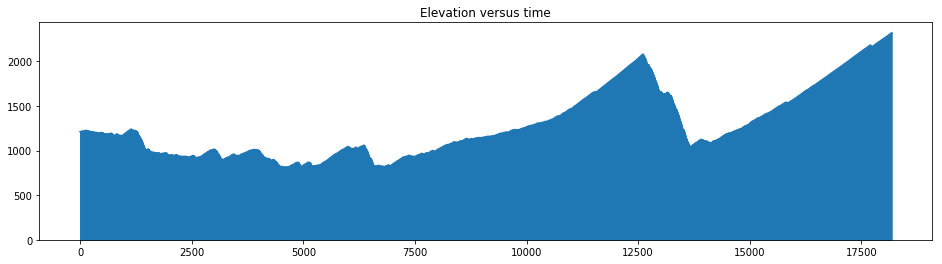

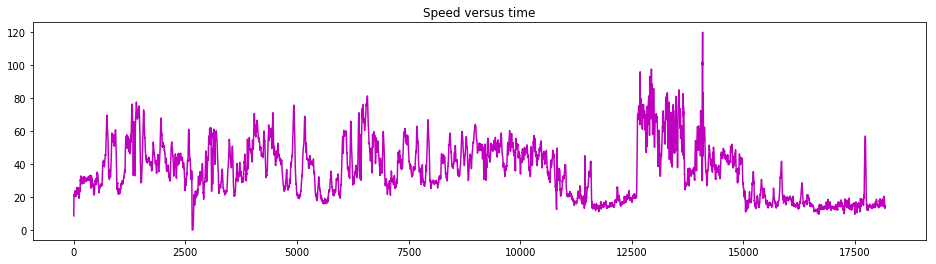

In [6]:

plt.figure(figsize=(16,4))
course.altitude.plot.area(title='Elevation versus time')
plt.figure(figsize=(16,4))
course.modelV.apply(lambda x: x*3.6).plot(c='m', title='Speed versus time')
print('Summary of modelled velocity')
course.modelV.apply(lambda x: x*3.6).describe()

## Power calculation

![title](PowerFormula.png)

In [7]:
def solveP(course, dt=1, mr=74, Cd=0.5,  A=0.5, Br=0, Vw=4, Bw=90, Pressure=1020, Temp=15, DP=False, Humidity=False, 
           Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.364, g=9.81, 
           If = 0.0885, Ir = 0.1085, smoothing = 5, plotIt=False):
    """Returns course with calculated power for given set of parameters by solving linear equation
    Accounts for rider direction as a bearing Br, wind velicity Vw and wind direction (from) Bw"""

    dv = (course.modelV.diff(smoothing)/smoothing).rolling(smoothing).mean()/dt
    course['rho'] = course.altitude.apply(lambda x: rhoCalc(Pressure=Pressure, Temp=Temp, DP=DP, Humidity=Humidity, Elevation = x))
    Ahw = Vw * np.cos((Bw-Br)*np.pi/180) # Apparent headwind

    
    Drag = course.rho / 8 * (4 * A * Cd + np.pi * (Cxf * df**2 + Cxr * dr**2 * (1-RS) ))
    theta = np.arctan(course.modelSlope.rolling(smoothing).mean()/100)
    Mech = (mr + mb + mfw + mrw) * g * (Crr * np.cos(theta) + np.sin(theta))
    Acc = (mr + mb + mfw + mrw + 4 * If / df**2 + 4 * Ir / dr**2) * dv
    course['Power'] = (Drag * (course.modelV + Ahw)**2 + Mech + Acc ) * course.modelV
    course.Power = course.Power.apply(lambda x: max(0, x) )

    if plotIt:
        plt.figure(figsize=(16,4))
        sm=10
        plt.plot((Drag * (course.modelV + Ahw)**2*course.modelV).rolling(sm).mean())
        plt.plot( (Mech*course.modelV).rolling(sm).mean(),c='r')
        plt.plot( (Acc*dv*course.modelV).rolling(sm).mean(),c='g')
        plt.plot(course.Power.rolling(sm).mean(),c='y')
        plt.ylim(-1000,1000)
        plt.show()
    
    return course

## First test - Laurens ten Dam data

In [8]:
# Laurens ten Dam
mr = 69
obs = HistoricWeather.weatherObs(d=20, m=7, y=2017, h=14, mi=0, s=0, town="grenoble", country='france')

obs

Pressure    1015.0
Humidity      43.0
Temp          29.0
WindDirn     277.0
Wind           6.0
Name: 2017-07-20 14:00:00, dtype: float64

###### Observation
In order to match actual average power, need to reduce Cd very significantly - there's a huge drafting benefit in the peloton: perhaps 60%!

In [9]:
Cd = 0.5 * 0.4
course = solveP(course,mr=mr,Vw=0, Cd=Cd, Pressure=obs.Pressure, Temp=obs.Temp, Humidity=obs.Humidity )    # reduce Cd to 70% due to drafting

('Full course (242)',
 242.0197807635733,
 'Last 30 mins (304)',
 290.7665130446332,
 'First hour (162)',
 154.6032132889837)

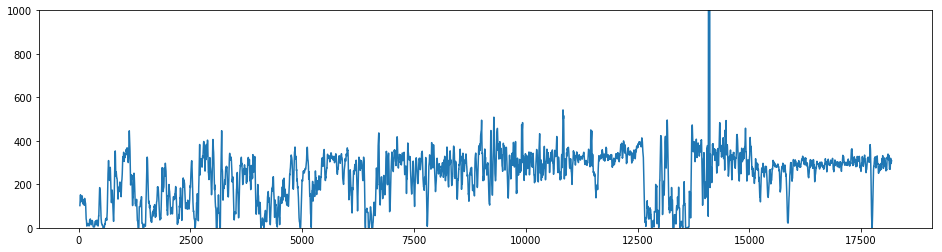

In [10]:
plt.figure(figsize=(16,4))
course.Power.rolling(30).mean().plot()
plt.ylim((0,1000))
'Full course (242)',course.Power.mean(),'Last 30 mins (304)',course.Power[-1800:].mean(), 'First hour (162)',course.Power[:3600].mean()

## Second test using some of my data

https://www.strava.com/activities/1088096275


In [11]:
course2 = read_gpx(gpx_file='Afternoon_Ride 170717.gpx')
mr = 73
obs = HistoricWeather.weatherObs(d=17, m=7, y=2017, h=10, mi=0, s=0, town="london", country='uk')

course2 = solveP(course2,mr=mr,Vw=0, Pressure=obs.Pressure, Temp=obs.Temp, Humidity=obs.Humidity )   

157.35613089813663

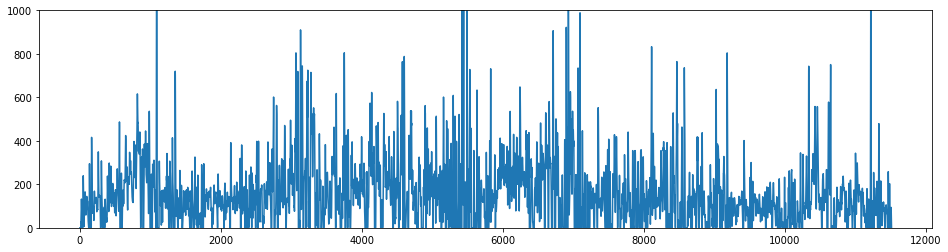

In [12]:
plt.figure(figsize=(16,4))
course2.Power.plot()
plt.ylim((0,1000))
course2.Power.mean()

In [13]:
import Strava_Download as strava
actual = strava.get_strava_activity(1088096275)

(0, 1000)

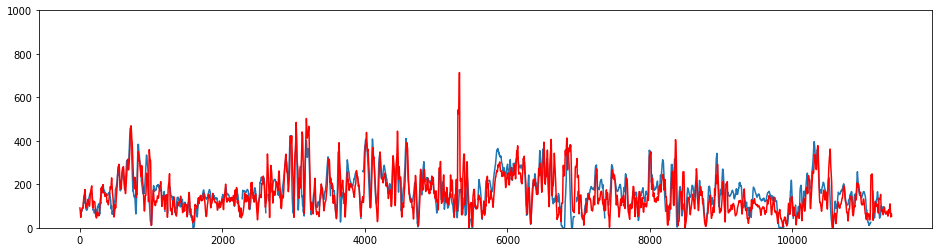

In [14]:
plt.figure(figsize=(16,4))
actual.watts.rolling(30).mean().plot()
course2.Power.rolling(30).mean().shift(-120).plot(c='r')
plt.ylim((0,1000))


In [15]:
actual.watts.mean(),course2.Power.mean()

(164.21481218364266, 157.35613089813663)

## Third test using some of my data

https://www.strava.com/activities/1092055102


In [16]:
course2 = read_gpx(gpx_file='Hillingdon_Vets_bunch_picked_up_a_prime.gpx')

Summary of modelled velocity


count    4098.000000
mean       39.208338
std         9.466514
min         0.000000
25%        38.079458
50%        40.757209
75%        43.571954
max        78.700031
Name: modelV, dtype: float64

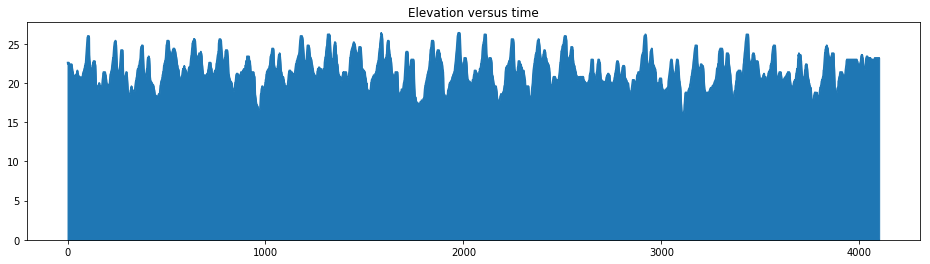

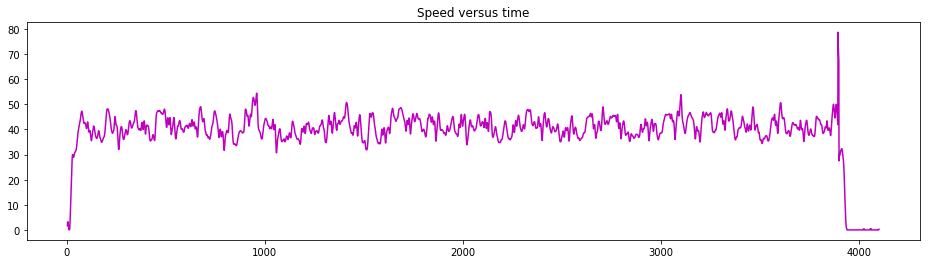

In [17]:
plt.figure(figsize=(16,4))
course2.altitude.plot.area(title='Elevation versus time')
plt.figure(figsize=(16,4))
course2.modelV.apply(lambda x: x*3.6).plot(c='m', title='Speed versus time')
print('Summary of modelled velocity')
course2.modelV.apply(lambda x: x*3.6).describe()

In [18]:
mr = 73
obs = HistoricWeather.weatherObs(d=19, m=7, y=2017, h=19, mi=30, s=0, town="london", country='uk')
Cd = 0.42 # drafting
course2 = solveP(course2,Cd=Cd, mr=mr,Vw=0, Pressure=obs.Pressure, Temp=obs.Temp, Humidity=obs.Humidity )   

263.350742165532

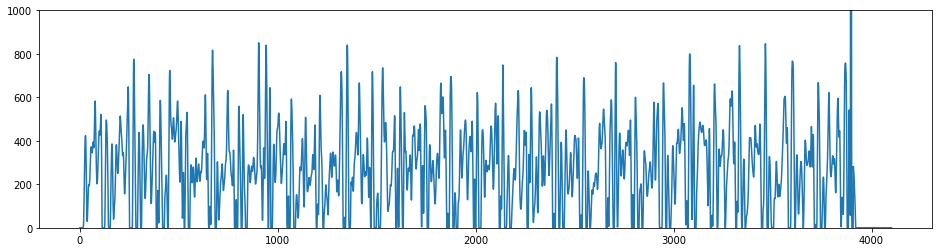

In [19]:
plt.figure(figsize=(16,4))
course2.Power.plot()
plt.ylim((0,1000))
course2.Power.mean()

In [20]:
import Strava_Download as strava
actual = strava.get_strava_activity(1092055102)

(0, 1100)

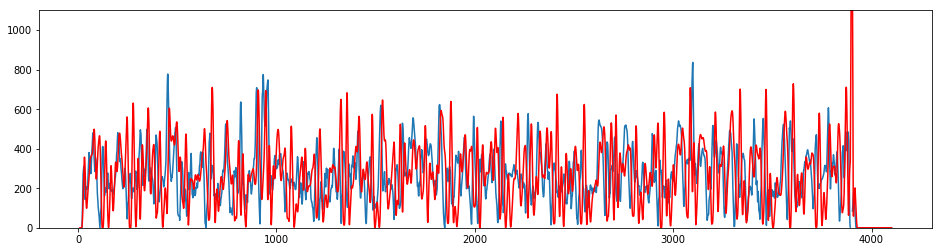

In [21]:
plt.figure(figsize=(16,4))
actual.watts.rolling(10).mean().plot()
course2.Power.rolling(10).mean().plot(c='r')
plt.ylim((0,1100))
#plt.plot(actual.watts.rolling(5).mean(),course2.Power.rolling(5).mean(),'ro')

In [22]:
actual.watts.mean(),course2.Power.mean()

(256.452125061065, 263.350742165532)

## Fourth test using Stuart Spies data

https://www.strava.com/activities/1091926038
Stuart's GPS records once every 2 seconds, giving less accurate speeds. This messes up the methodology.

In [23]:
course2 = read_gpx(gpx_file='Hurty_ouch_gentlemanly_4_up_win_.gpx', dt=2)

In [24]:
course2.modelV = course2.modelV.rolling(15).mean()
mr = 72
obs = HistoricWeather.weatherObs(d=17, m=7, y=2017, h=10, mi=0, s=0, town="london", country='uk')

course2 = solveP(course2,dt=2,mr=mr,Vw=0, Pressure=obs.Pressure, Temp=obs.Temp, Humidity=obs.Humidity )   

Summary of modelled velocity


count    2057.000000
mean       46.356505
std         8.539369
min        15.019630
25%        39.529686
50%        45.944149
75%        53.107527
max        67.771249
Name: modelV, dtype: float64

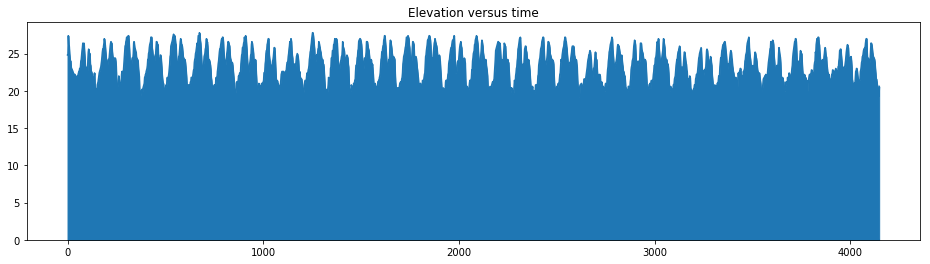

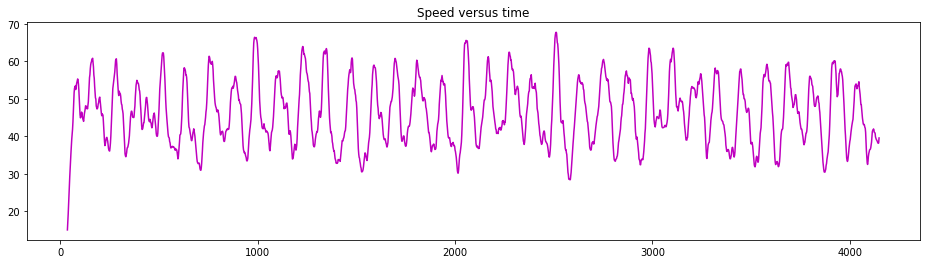

In [25]:
plt.figure(figsize=(16,4))
course2.altitude.plot.area(title='Elevation versus time')
plt.figure(figsize=(16,4))
course2.modelV.apply(lambda x: x*3.6).plot(c='m', title='Speed versus time')
print('Summary of modelled velocity')
course2.modelV.apply(lambda x: x*3.6).describe()

455.7897386208254

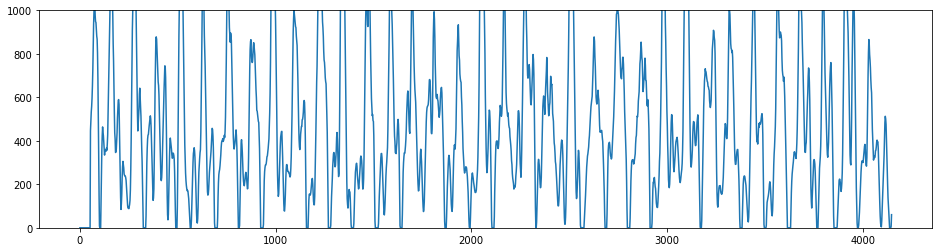

In [26]:
plt.figure(figsize=(16,4))
course2.Power.plot()
plt.ylim((0,1000))
course2.Power.mean()

## Fifth test - Chris Froome "Empty the tank"
Download GPX for Froome's ride. Load load it and plot modelled speed cf https://www.strava.com/activities/1379317668/overview Then estimate power, assuming solo riding cDA = 0.25

![title](Froomey.png)

In [27]:
course = read_gpx(gpx_file='_Empty_the_tank_.gpx')

Summary of modelled velocity


count    21280.000000
mean        45.574069
std         14.733920
min          5.554461
25%         36.037235
50%         46.203717
75%         55.682351
max         89.596213
Name: modelV, dtype: float64

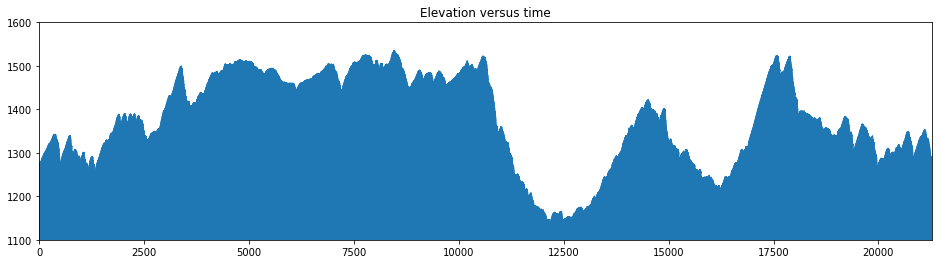

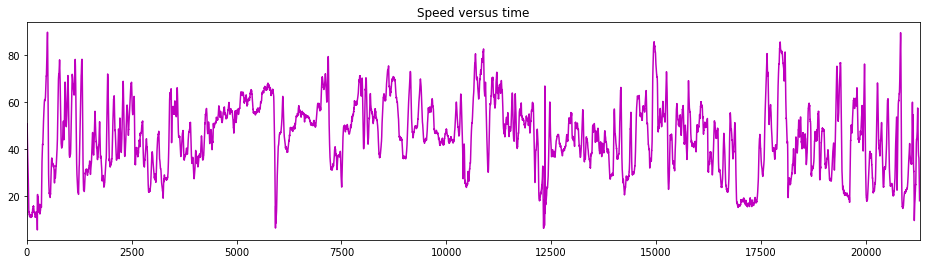

In [28]:

plt.figure(figsize=(16,4))
course.altitude.plot.area(title='Elevation versus time')
plt.ylim((1100,1600))
plt.xlim((0,len(course)))
plt.figure(figsize=(16,4))
course.modelV.apply(lambda x: x*3.6).plot(c='m', title='Speed versus time')
plt.xlim((0,len(course)))

print('Summary of modelled velocity')
course.modelV.apply(lambda x: x*3.6).describe()

### Factors affecting air density
We need to know the weather conditions to derive the air density. Froome set of at 6:32am, when it was still quite chilly. Various factors affected the air density during his ride.
- It warmed up from 15 degrees to 32 degrees during the ride. 
- We use the average of 24 for the whole ride
- His Garmin recorded an altitude range from 1137m to 1535m. However we can see that his start and end altitudes were recorded as 1278m and 1290m, when the actual altitude of this location was 1380m. http://elevationmap.net/douw-steyn-dr-w-zevenfontein-407-jr-midrand-south-africa?latlngs=(-25.976938180462998,27.99527834250489) 
- We conclude that his average altitude was 1473m and use this as an elevation adjustment for the whole ride

In [29]:
course.altitude[:5], course.altitude[-5:], course.altitude.describe()

(0    1278.0
 1    1277.2
 2    1276.0
 3    1276.0
 4    1275.6
 Name: altitude, dtype: float64, 21279    1289.8
 21280    1289.8
 21281    1290.4
 21282    1290.6
 21283    1290.6
 Name: altitude, dtype: float64, count    21284.000000
 mean      1373.070541
 std        104.974758
 min       1137.000000
 25%       1298.600000
 50%       1374.000000
 75%       1476.000000
 max       1535.200000
 Name: altitude, dtype: float64)

In [30]:
course[['lat','lon']][:5], course[['lat','lon']][-5:], course[['lat','lon']].describe()

(         lat        lon
 0 -25.977081  27.994839
 1 -25.977141  27.994720
 2 -25.977205  27.994600
 3 -25.977269  27.994479
 4 -25.977324  27.994352,              lat        lon
 21279 -25.977052  27.994654
 21280 -25.977036  27.994703
 21281 -25.977017  27.994746
 21282 -25.976994  27.994786
 21283 -25.976972  27.994824,                 lat           lon
 count  21284.000000  21284.000000
 mean     -25.967937     27.548840
 std        0.087146      0.267005
 min      -26.186008     27.044336
 25%      -26.004662     27.329442
 50%      -25.967095     27.565071
 75%      -25.916865     27.777177
 max      -25.786695     27.994839)

### WeatherUnderground
This provides hourly observations for Johannesburg. Pressure was fairly constant. This is always quoted for sea level, so it needs to be adjusted. Humidity varied a bit but this has very little impact. Winds were light enough to make no difference.

In [31]:
IFrame('https://www.wunderground.com/history/airport/FAJB/2018/1/28/DailyHistory.html?req_city=Johannesburg&req_state=GT&req_statename=South+Africa&reqdb.zip=00000&reqdb.magic=1&reqdb.wmo=68361', width=700, height=500)

In [32]:
Temp,Pressure,Elevation = 24,1020,1473
g =  9.80665   # gravitational constant, m/sec^2
M = 28.9644/1000    # molecular weight of dry air, kg/mol
L =  6.5/1000  # temperature lapse rate, deg K/m
R = 8.31432    # gas constant, J/ mol*deg K 
TempK = Temp + 273.15
localP = Pressure * 100 * (TempK / (TempK + L * Elevation)) ** (g*M/(R*L)) # multiply by 100 to get kg/m^3 and adjust for elevation
print('Elevation adjusted pressure {:.2f} mBar'.format(localP/100))


Elevation adjusted pressure 863.40 mBar


### Power calculation
Choice of cDA has a big impact on the results. The assumption is made that Froome rides in a very aerodynamic position resulting in a cDA of 0.20 versus more typical 0.25 (frontal area of 0.5 square metres). This assumption is absolutely critical in estimating power. As seen previously with LvD example, this had to be reduced. Also not sure if Froome was drafting with behind riders.

In [33]:
mr = 70
Cd = 0.5 * .5
Humidity = 55
course = solveP(course,mr=mr,Vw=1, Bw=90, Cd=Cd, Pressure=localP/100, Temp=Temp, Humidity=Humidity )   
#course = solveP(course,mr=mr,Vw=0, Cd=Cd, Pressure=Pressure, Temp=Temp, Humidity=Humidity )    

('Full course',
 244.26853170138693,
 'Last 60 mins',
 203.37150519153323,
 'First hour',
 245.3644477013644)

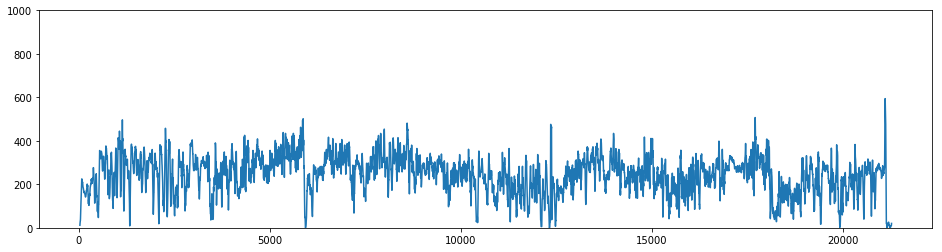

In [34]:
plt.figure(figsize=(16,4))
course.Power.rolling(30).mean().plot()
plt.ylim((0,1000))
'Full course',course.Power.mean(),'Last 60 mins',course.Power[-3600:].mean(), 'First hour',course.Power[:3600].mean()

In [35]:
course.Power.describe()

count    21284.000000
mean       244.268532
std        167.886664
min          0.000000
25%        129.337698
50%        247.262552
75%        342.819582
max       4239.496813
Name: Power, dtype: float64

- average power ridiculously high --  need to reduce CdA to obtain reasonable results
- clearly some spurious extreme observations that need to be capped
- The elevation adjustment for air pressure was very important (otherwise power works out to be much higher).

In [36]:
powerCurve = []
course['PowerCap'] = course.Power
course.PowerCap[course.PowerCap>1200] = 1200
for t in range(5,len(course)):
               powerCurve += [[t, course.PowerCap.rolling(t).mean().max()]]
        

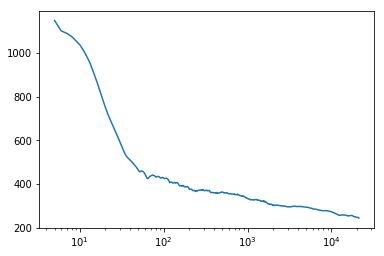

In [37]:
x,y = [i for i in zip(*powerCurve)]
plt.semilogx(x,y);

In [38]:
powerCurve[3595], powerCurve[3595][1]/mr

([3600, 298.50202979842584], 4.264314711406083)

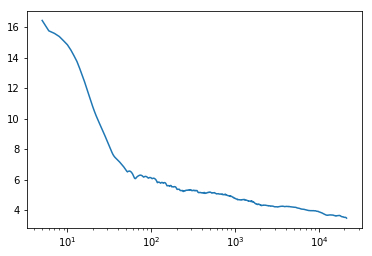

In [39]:
x,y = [i for i in zip(*powerCurve)]
ym =[i/mr for i in y]
plt.semilogx(x,ym);

Based on these assumptions, the figures are not too far away from published test results http://www.scuoladicorsa.it/sdc/wp-content/uploads/2015/12/ChrisFroome-BodyCompositionandAerobicPhysiology_.pdf<br>
However it is pretty clear that Froome was being motor-paced for some or all of this ride



In [40]:
course.Power[course.Power>1000]

767      1014.885487
768      1090.812790
769      1031.394823
3399     1063.915305
3571     1009.874222
3572     1169.509806
3573     1204.600342
3574     1048.694780
12351    1680.560522
12352    2507.402323
12353    3373.761688
12354    4239.496813
16056    1026.534127
17995    1035.359554
17996    1172.802763
17997    1130.579288
18035    1046.618744
18056    1031.233430
18057    1148.217436
18058    1073.273997
19818    1155.466180
19819    1300.159864
19820    1263.753496
19821    1066.015310
21106    1044.363502
21107    1084.055102
21108    1105.403438
21109    1142.776795
21110    1134.887505
21111    1103.253361
21112    1020.707244
Name: Power, dtype: float64

## Sixth test - Chris Froome "TT Bike Squeeeeze"
Download GPX for Froome's ride. Load load it and plot modelled speed cf https://www.strava.com/activities/1343171851/overview Then estimate power

![title](FroomeyTT.png)

In [41]:
course = read_gpx(gpx_file='TT_Bike_Squeeeeze_.gpx')

Summary of modelled velocity


count    15992.000000
mean        36.510293
std         13.103869
min          5.065404
25%         26.688365
50%         35.412313
75%         45.750494
max         86.819530
Name: modelV, dtype: float64

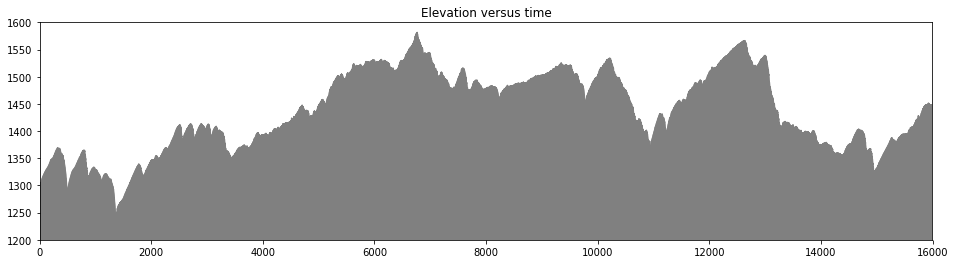

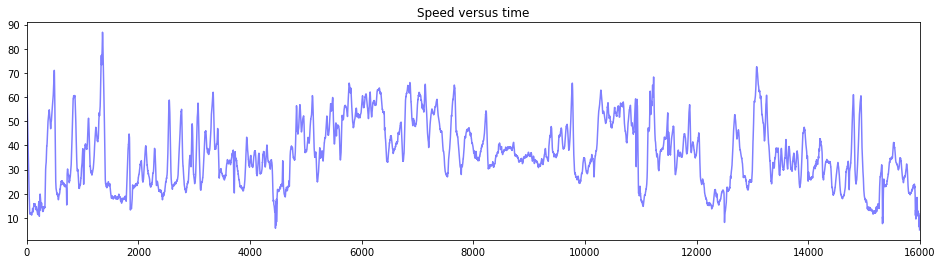

In [42]:

plt.figure(figsize=(16,4))
course.altitude.plot.area(title='Elevation versus time',color='grey')
plt.ylim((1200,1600))
plt.xlim((0,len(course)))
plt.figure(figsize=(16,4))
course.modelV.apply(lambda x: x*3.6).plot(c='b', title='Speed versus time', alpha=0.5)
plt.xlim((0,len(course)))

print('Summary of modelled velocity')
course.modelV.apply(lambda x: x*3.6).describe()

### Factors affecting air density
We need to know the weather conditions to derive the air density. Froome set of at 6:36am, when it was still relatively cool. Various factors affected the air density during his ride.
- It warmed up from 18 degrees to 40 degrees during the ride. 
- We use the average of 29 for the whole ride
- His Garmin recorded an altitude range from 1242m to 1581m. However we can see that his starting altitude was recorded as 1305m, when the actual altitude of this location was 1380m. http://elevationmap.net/douw-steyn-dr-w-zevenfontein-407-jr-midrand-south-africa?latlngs=(-25.976938180462998,27.99527834250489) 
- We conclude that his average altitude recorded at 1436m needs to be corrected by 75m to 1511m and use this as an elevation adjustment for the whole ride

In [43]:
course.altitude[:5], course.altitude.describe()

(0    1305.4
 1    1304.8
 2    1303.6
 3    1302.6
 4    1302.0
 Name: altitude, dtype: float64, count    15996.000000
 mean      1436.104376
 std         72.456485
 min       1242.200000
 25%       1379.400000
 50%       1433.200000
 75%       1500.200000
 max       1581.400000
 Name: altitude, dtype: float64)

In [44]:
course[['lat','lon']][:5],  course[['lat','lon']].describe()

(         lat        lon
 0 -25.977104  27.994959
 1 -25.977162  27.994804
 2 -25.977225  27.994649
 3 -25.977288  27.994495
 4 -25.977354  27.994344,                 lat           lon
 count  15996.000000  15996.000000
 mean     -26.031657     27.683990
 std        0.079706      0.166129
 min      -26.221416     27.434061
 25%      -26.070080     27.543382
 50%      -26.005090     27.700426
 75%      -25.982053     27.823777
 max      -25.921363     27.994959)

### WeatherUnderground
This provides hourly observations for Johannesburg. Pressure was fairly constant. This is always quoted for sea level, so it needs to be adjusted. Humidity varied a bit but this has very little impact. Winds were light enough to make no difference.

In [45]:
from IPython.display import IFrame
IFrame('https://www.wunderground.com/history/airport/FAJB/2018/1/06/DailyHistory.html?req_city=Johannesburg&req_state=GT&req_statename=South+Africa&reqdb.zip=00000&reqdb.magic=1&reqdb.wmo=68361', width=700, height=500)

### Assumptions for temperature, pressure and elevation

In [46]:
Temp,Pressure,Elevation = 29,1018,1511
g =  9.80665   # gravitational constant, m/sec^2
M = 28.9644/1000    # molecular weight of dry air, kg/mol
L =  6.5/1000  # temperature lapse rate, deg K/m
R = 8.31432    # gas constant, J/ mol*deg K 
TempK = Temp + 273.15
localP = Pressure * 100 * (TempK / (TempK + L * Elevation)) ** (g*M/(R*L)) # multiply by 100 to get kg/m^3 and adjust for elevation
print('Elevation adjusted pressure {:.2f} mBar'.format(localP/100))


Elevation adjusted pressure 860.46 mBar


### Power calculation
Choice of cDA has a big impact on the results. We know Froome was on his TT bike, so the assumption is made that he rides in a very aerodynamic position resulting in a cDA of 0.22 versus more typical 0.25 (frontal area of 0.5 square metres). This assumption is absolutely critical in estimating power. As seen previously with LvD example, this had to be reduced. Also not sure if Froome was drafting with behind riders.

In [47]:
mr = 70
Cd = 0.5 * 0.22 / 0.25
Humidity = 50
course = solveP(course,mr=mr,Vw=0, Bw=90, Cd=Cd, Pressure=localP/100, Temp=Temp, Humidity=Humidity )   
#course = solveP(course,mr=mr,Vw=0, Cd=Cd, Pressure=Pressure, Temp=Temp, Humidity=Humidity )    

In [48]:
course.Power.describe()

count    15996.000000
mean       205.025936
std        144.398351
min          0.000000
25%        103.662519
50%        191.891946
75%        287.507355
max       1056.576005
Name: Power, dtype: float64

Rough estimate of effort from 4800 to 12000

In [49]:
s,e = 4800, 12000
course.modelV[s:e].mean()*3.6, course.Power[s:e].mean(), course.step[s:e].sum()/1000,(course.index[e]-course.index[s])/3600

(43.678304196228154, 270.7299343843328, 87.35813807100907, 2.0)

- there are no spurious extreme observations 
- The elevation adjustment for air pressure was very important (otherwise power works out to be much higher).

In [50]:
course['Shade']=0
course.loc[s:e,'Shade']=1000


('Full course', 205.02593554079357)

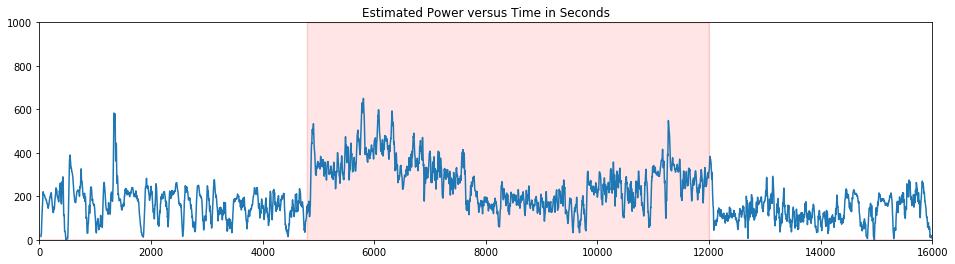

In [51]:
plt.figure(figsize=(16,4))
course.Power.rolling(30).mean().plot(title='Estimated Power versus Time in Seconds')
course.Shade.plot.area(alpha=0.1,color='r')
plt.ylim((0,1000))
plt.xlim((0,len(course)))
'Full course',course.Power.mean()

In [52]:
powerCurve = []
course['PowerCap'] = course.Power
course.PowerCap[course.PowerCap>1200] = 1200
for t in range(5,len(course)):
               powerCurve += [[t, course.PowerCap.rolling(t).mean().max()]]
        

/Users/Gavin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


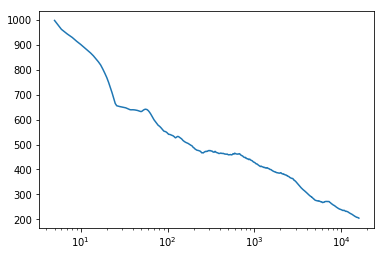

In [53]:
x,y = [i for i in zip(*powerCurve)]
plt.semilogx(x,y);

In [54]:
powerCurve[3595], powerCurve[3595][1]/mr

([3600, 320.54269336217686], 4.5791813337453835)

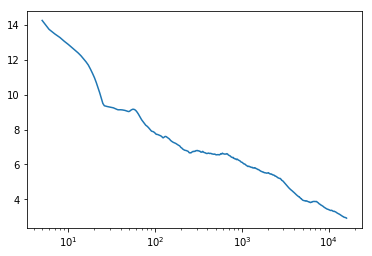

In [55]:
x,y = [i for i in zip(*powerCurve)]
ym =[i/mr for i in y]
plt.semilogx(x,ym);

Based on these assumptions, the figures are not too far away from published test results http://www.scuoladicorsa.it/sdc/wp-content/uploads/2015/12/ChrisFroome-BodyCompositionandAerobicPhysiology_.pdf<br>
However it is pretty clear that Froome was being motor-paced for some or all of this ride



### Sensitivity Analysis

In [56]:
def sensPower(Temp=29, Pressure=1018, Elevation=1511 , Cd = 0.5 * 0.22 / 0.25, course=course):
    g =  9.80665   # gravitational constant, m/sec^2
    M = 28.9644/1000    # molecular weight of dry air, kg/mol
    L =  6.5/1000  # temperature lapse rate, deg K/m
    R = 8.31432    # gas constant, J/ mol*deg K 
    TempK = Temp + 273.15
    localP = Pressure * 100 * (TempK / (TempK + L * Elevation)) ** (g*M/(R*L)) # multiply by 100 to get kg/m^3 and adjust for elevation
    mr = 70
    Humidity = 50
    course = solveP(course,mr=mr,Vw=0, Bw=90, Cd=Cd, Pressure=localP/100, Temp=Temp, Humidity=Humidity )   
    return course.Power.mean()


In [57]:
sensPower(Cd=0.4)

194.7311978242709